<a href="https://colab.research.google.com/github/Jvasvil/Proyecto/blob/main/Copia_de_Copia_de_TProg2_TF_23I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Köppen-Geiger climate classification (Peel et al., 2007; DOI: https://doi.org/10.5194/hess-11-1633-2007)

In [ ]:
%%capture
!pip install rioxarray
!pip install geopandas
!pip install cartopy
!pip install shapely --no-binary shapely --force
!pip install --upgrade --force-reinstall numpy

In [ ]:
### Configuración de entorno
from google.colab import drive
drive.mount('/content/drive/')

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, xarray as xr, rioxarray, geopandas as gpd
from datetime import datetime

path = '/content/drive/MyDrive/4Work_TProg2/' # Directorio de trabajo
path_data = path + 'Data_TProg2/'             # Directorio de datos
os.chdir(path)

#### Shapefile
DPTO = gpd.read_file(path_data + 'Copia de PE_DEPARTAMENTOS.zip').to_crs('EPSG:4326')
REG = gpd.read_file(path_data + 'Copia de PE_REGIONES.zip').to_crs('EPSG:4326')

#### Visualización
import matplotlib.pyplot as plt,matplotlib as mpl,matplotlib.ticker as mticker,matplotlib.dates as mdates,cartopy.crs as ccrs
from cartopy.feature import BORDERS, OCEAN, LAND, COASTLINE
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

crs = ccrs.PlateCarree()    # Proyección

Mounted at /content/drive/


In [ ]:
###### Lectura de datos
pp = xr.open_dataarray(path_data + 'PISCOp_daily_2p1.nc', decode_times = False) / 10 # cm
tx = xr.open_dataarray(path_data + 'PISCOtx_monthly_1.1.nc', decode_times = False)  # °C
tn = xr.open_dataarray(path_data + 'PISCOtn_monthly_1.1.nc', decode_times = False)

tx['T'] = pd.date_range('1981-01-01', '2016-12-31', freq = 'M')    # Dimensión de tiempo
tn['T'] = pd.date_range('1981-01-01', '2016-12-31', freq = 'M')
pp['T'] = pd.date_range('1981-01-01', '2016-12-31', freq = 'd')

pp = xr.where(pp.resample(T = 'M').mean().isnull(), np.nan,        # PP acumulado mensual
              pp.resample(T = 'M').sum())

###### Ajuste de grillados
tx = tx.sel(Y = slice(0.95+0.1, -18.75), X = slice(-81.25, -68.05))
tn = tn.sel(Y = slice(0.95+0.1, -18.75), X = slice(-81.25, -68.05))
pp = pp.interp_like(tx)

###### Cálculo de climatologías 1981-2010
tp = (tx + tn) / 2  # Temperatura promedio

T = tp.sel(T = slice('1981','2010')).groupby('T.month').mean('T').rio.set_crs('EPSG:4326')
P = xr.where(pp.sel(T = slice('1981','2010')).groupby('T.month').mean().isnull(), np.nan,
             pp.sel(T = slice('1981','2010')).groupby('T.month').sum('T')).rio.set_crs('EPSG:4326')

###### Cálculo de parámetros para la clasificación (Peel et al., 2007)
MAT = T.mean('month')   # mean annual temperature
Thot = T.max('month')   # temperature of the hottest month
Tcold = T.min('month')  # temperature of the coldest month
Tmon10 = xr.where(T.mean('month').isnull(), np.nan, (T > 10).sum('month'))  # number of months where the temperature is above 10

summer = [10, 11, 12, 1, 2, 3]  # ONDJFM
winter = [4, 5, 6, 7, 8, 9]     # AMJJAS
MAP = xr.where(P.mean('month').isnull(), np.nan, P.sum('month'))   # mean annual precipitation
Pdry = P.min('month')   # precipitation of the driest month
Psdry = P.sel(month = summer).min('month')  # precipitation of the driest month in summer
Pwdry = P.sel(month = winter).min('month')  # precipitation of the driest month in winter
Pwet = P.max('month')   # precipitation of the wettest month
Pswet = P.sel(month = summer).max('month')  # precipitation of the wettest month in summer
Pwwet = P.sel(month = winter).max('month')  # precipitation of the wettest month in winter
Pthreshold = xr.where(P.sel(month = winter).sum('month') > 0.7*MAP, 2*MAT,      # if 70% of MAP occurs in winter then Pthreshold = 2*MAT
             xr.where(P.sel(month = summer).sum('month') > 0.7*MAP, 2*MAT+28,   # if 70% of MAP occurs in summer then Pthreshold = 2*MAT+28
                                                                    2*MAT+14))  # otherwise Pthreshold = 2 * MAT + 14
# Pthreshold se comparar con la MAT como indicador de la tasa de evaporación

In [ ]:
###### Köppen-Geiger climate classification
# Explicación de where: xr.where(condición, "si se cumple esa condición, se asigna X", "y si no, se asigna Y")
KoppenG = xr.where(P.mean('month').isnull(), np.nan,
            xr.where(MAP < 10 * Pthreshold,             # B: Arid
                xr.where(MAP < 5 * Pthreshold,
                        xr.where(MAT >= 18,    'BWh',   #  - Desert hot
                                               'BWk'),  #  - Desert cold
                        xr.where(MAT >= 18,    'BSh',   #  - Steppe hot
                                               'BSk')), #  - Steppe cold
            xr.where(10 < Thot,
                xr.where(Tcold >= 18,                           # A: Tropical
                        xr.where(Pdry >= 60,           'Af',    #  - Rainforest
                        xr.where(Pdry >= 100 - MAP/25, 'Am',    #  - Monsoon
                                                       'Aw')),  #  - Savannah

                    xr.where(Tcold <= 0,                        # D: Cold
                        xr.where((Psdry < 40) & (Psdry < Pwwet/3),
                            xr.where(Thot >= 22,  'Dsa',        #  - Dry Summer Hot summer
                            xr.where(Tmon10 >= 4, 'Dsb',        #  - Dry Summer Warm summer
                            xr.where(Tcold < -38, 'Dsd',        #  - Dry Summer Very Cold winter
                                                  'Dsc'))),     #  - Dry Summer Cold summer
                        xr.where(Pwdry < Pswet/10,
                            xr.where(Thot >= 22,  'Dwa',        #  - Dry Winter Hot summer
                            xr.where(Tmon10 >= 4, 'Dwb',        #  - Dry Winter Warm summer
                            xr.where(Tcold < -38, 'Dwd',        #  - Dry Winter Very Cold winter
                                                  'Dwc'))),     #  - Dry Winter Cold winter

                            xr.where(Thot >= 22,  'Dfa',        #  - Whitout dry season Hot summer
                            xr.where(Tmon10 >= 4, 'Dfb',        #  - Whitout dry season Warm summer
                            xr.where(Tcold < -38, 'Dfd',        #  - Whitout dry season Very Cold winter
                                                  'Dfc'))))),   #  - Whitout dry season Cold summer

                        xr.where((Psdry<40) & (Psdry<Pwwet/3),  # C: Temperate
                            xr.where(Thot >= 22,  'Csa',        #  - Dry Summer Hot summer
                            xr.where(Tmon10 >= 4, 'Csb',        #  - Dry Summer Warm summer
                                                  'Csc',)),     #  - Dry Summer Cold summer
                        xr.where(Pwdry < Pswet/10,
                            xr.where(Thot >= 22,  'Cwa',        #  - Dry Winter Hot summer
                            xr.where(Tmon10 >= 4, 'Cwb',        #  - Dry Winter Warm summer
                                                  'Cwc',)),     #  - Dry Winter Cold summer

                            xr.where(Thot >= 22,  'Cfa',        #  - Whitout dry season Hot summer
                            xr.where(Tmon10 >= 4, 'Cfb',        #  - Whitout dry season Warm summer
                                                  'Cfc')))))),  #  - Whitout dry season Cold summer
                                          # E: Polar
            xr.where(Thot > 0, 'ET',     #  - Tundra
                               'EF'))))  #  - Frost

In [ ]:
###### Insumos para la visualización
KoppenGClass = ['Af','Am','Aw',     # Lista de climas según Köppen-Geiger
               'BWh','BWk','BSh','BSk',
               'Csa','Csb','Csc',
               'Cwa','Cwb','Cwc',
               'Cfa','Cfb','Cfc',
               'Dsa','Dsb','Dsc','Dsd',
               'Dwa','Dwb','Dwc','Dwd',
               'Dfa','Dfb','Dfc','Dfd',
               'ET' ,'EF']
KoppenGValue = np.arange(len(KoppenGClass))     # Indicador numérico del clima

KoppenGColor = ['#0000ff','#0178ff','#47a9fa',  # Paleta de colores (Beck et al., 2018)
                '#fe0000','#fe9594','#f3a601','#ffdc64',
                '#ffff00','#c7c800','#969600',
                '#96ff97','#63c863','#329733',
                '#c9fe52','#63ff32','#31c700',
                '#ff00ff','#c900c8','#963195','#966597',
                '#aaafff','#5a78db','#4b4fb4','#310087',
                '#01ffff','#36c8ff','#027d7d','#00475f',
                '#b3b3b3','#666666']
color_dict = {v:c for v, c in zip(KoppenGClass,KoppenGColor) }

from matplotlib.colors import ListedColormap
cmap_KoppenG = ListedColormap(KoppenGColor, name = 'KoppenG', N = len(KoppenGValue))
cmap_KoppenG.set_bad(color = 'white')   # Seleccionar color de nan

# Transformación de los climas: 'Af' = 0, 'Am' = 1, ...
def pandas_replace(da, to_replace, value):
    # Reemplaza valores en un DataArray, similar a df.replace
    # Reference: https://github.com/pydata/xarray/issues/6377
    df = pd.DataFrame()
    df["values"] = da.values.ravel()
    df["values"].replace(to_replace, value, inplace=True)
    return da.copy(data=df["values"].values.reshape(da.shape))

KoppenG2 = pandas_replace(KoppenG, KoppenGClass, KoppenGValue)\
                .rio.write_crs('EPSG:4326').rio.set_spatial_dims(x_dim = 'X', y_dim = 'Y')
KoppenG_PERU = [KoppenGClass[idx] for idx in np.unique(KoppenG2)[:-1].astype(int)]  # Lista de climas en el Perú
# print(KoppenG_PERU)

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/usr/local/lib/python3.10/dist-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/usr/local/lib/python3.10/dist-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is dep

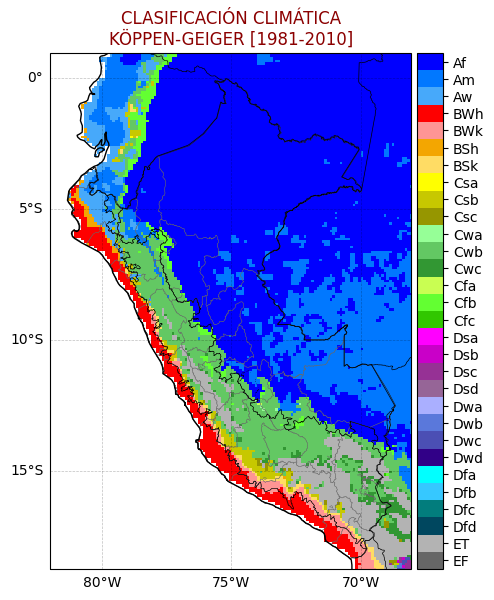

In [ ]:
###### Visualización: climas en el Perú

cbar_kws = dict(pad = 0.01, ticks = KoppenGValue)
fig, ax = plt.subplots(figsize = (8,8),
                       subplot_kw = dict(projection=ccrs.PlateCarree(), facecolor='white'))

PLT = KoppenG2.plot(ax = ax, transform = ccrs.PlateCarree(),
                    cmap = cmap_KoppenG, vmin = KoppenGValue[0]-0.5, vmax = KoppenGValue[-1]+0.5, cbar_kwargs = cbar_kws)
ax.set_extent([-82, -68.05, -18.75, 0.95])

# Configuración de la barra de colores
ax_cbar = ax.collections[0].colorbar.ax
ax_cbar.set_yticklabels(KoppenGClass)
ax_cbar.invert_yaxis()

# Agregar features
ax.add_feature(BORDERS, color='black', lw = 0.5, zorder = 2)
ax.coastlines('50m')
ax.set_title('CLASIFICACIÓN CLIMÁTICA\nKÖPPEN-GEIGER [1981-2010]', color = 'darkred')
DPTO.boundary.plot(ax = ax, edgecolor='dimgrey', linewidth = 0.25, zorder = 1)
REG.boundary.plot(ax = ax, edgecolor='black', linewidth = 0.3, zorder = 2)

# Grillado
grids = ax.axes.gridlines(color='black', alpha=0.25, linestyle='--', linewidth = 0.5,
                          crs=ccrs.PlateCarree(), draw_labels=True)

grids.xlabels_top = False; grids.ylabels_right = False    # Desactivar labels innecesarios

grids.xlocator = mticker.FixedLocator([x for x in range(-80,-70+5, 5)])  # labels x
grids.ylocator = mticker.FixedLocator([y for y in range(-20,  0+5, 5)])  # labels y
grids.xformatter = LONGITUDE_FORMATTER; grids.yformatter = LATITUDE_FORMATTER

plt.subplots_adjust(bottom = 0.255, top = 0.9, left = 0.1, right = 0.9, wspace = 0.02, hspace = 0.15)

plt.show()
fig.savefig(path + f'KoppenG1.png',
            transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

In [ ]:
###### Distribución regional y total
KoppenG_DF = pd.DataFrame(columns = ['Costa', 'Sierra', 'Selva'],
                          index = KoppenGValue)

# Frecuencia de cada clima según le región natural
for i, r in REG.set_index('Nm_RegNat').iterrows():
    shp = REG.set_index('Nm_RegNat').loc[[i], 'geometry'].to_crs('EPSG:4326')

    val, count = np.unique(KoppenG2.rio.clip(shp, shp.crs, drop = True), return_counts = True)
    for j in range(len(val)):
        if not np.isnan(val[j]): KoppenG_DF.loc[val[j], i] = count[j]

KoppenG_DF.index = KoppenGClass
KoppenG_DF_pReg = KoppenG_DF / KoppenG_DF.sum() * 100       # % regional
KoppenG_DF_pTot = KoppenG_DF / KoppenG_DF.sum().sum() * 100 # % total

In [ ]:
###### Distribución altitudinal
# Lectura y adaptación del DEM a las dimensiones de KoppenG
DEM = rioxarray.open_rasterio(path_data + 'Copia de DEM_1km.tif').rio.write_crs('EPSG:4326')\
               .coarsen(x=10, y=10, boundary = 'trim').mean()\
               .sel(y = slice(0.95+0.1, -18.75), x = slice(-81.25, -68.05))\
               .interp_like(KoppenG.rename({'X':'x', 'Y':'y'}))

bins = [0, 1000, 2000, 3000, 4000, 5000]    # Categorización
DEM_levels = xr.apply_ufunc(np.digitize, DEM, kwargs={'bins': bins})
DEM_levels = xr.where(DEM.isnull(), np.nan, DEM_levels).rio.write_crs('EPSG:4326')

# Unión a un mismo DF
DF_Levels = xr.Dataset({'KoppenG':KoppenG.rename({'X':'x', 'Y':'y'}),
                        'Level':DEM_levels}).drop_vars(['band', 'spatial_ref']).to_dataframe()\
              .dropna().reset_index(drop = True)

DF_Levels['a'] = 1
DF_Levels = DF_Levels.groupby(['KoppenG','Level']).sum().unstack()
DF_Levels.columns = ['1000 <', '1000', '2000', '3000', '4000', '< 5000']
DF_Levels_pLev = DF_Levels / DF_Levels.sum() * 100

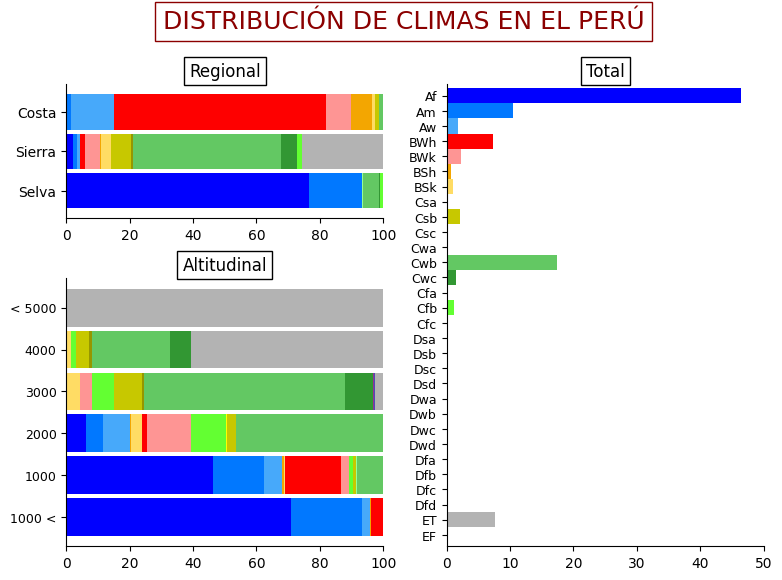

In [ ]:
###### Visualización: distribución climas en el Perú
fig, Ax = plt.subplots(nrows = 2, ncols = 2, figsize = (9,6),
                       gridspec_kw={'height_ratios': [1, 2]})

# Distribución regional
KoppenG_DF_pReg.T.dropna(how = 'all', axis = 1).\
                plot.barh(ax = Ax[0,0], stacked = True, width = 0.9,
                          color = [KoppenGColor[i] for i,j in enumerate(KoppenG_DF_pReg.notna().any(axis = 1).values) if j],
                          xlim = (0, 100), xticks = np.arange(0, 100+1, 20), legend = None)
Ax[0,0].set_title('Regional', bbox = dict(boxstyle='square', fc='white', ec='k'))   # Título
Ax[0,0].invert_yaxis()  # Invertir eje Y

# Distribución altitudinal
DF_Levels_pLev.T.dropna(how = 'all', axis = 1).\
                plot.barh(ax = Ax[1,0], stacked = True, width = 0.9,
                          color = [color_dict[v] for v in DF_Levels_pLev.notna().any(axis = 1).index],
                          xlim = (0, 100), xticks = np.arange(0, 100+1, 20), legend = None)
Ax[1,0].tick_params('y', labelsize  = 9)
Ax[1,0].set_title('Altitudinal', bbox = dict(boxstyle='square', fc='white', ec='k'))

# Distribución total
gs = Ax[0, 1].get_gridspec()        # Adaptación para un Axes de doble tamaño
for ax in Ax[:,1]: ax.remove()

Ax2 = fig.add_subplot(gs[:, -1])
KoppenG_DF_pTot.sum(axis = 1).plot.barh(ax = Ax2, width = 1, color = KoppenGColor, xlim = (0, 50))
Ax2.set_title('Total', bbox = dict(boxstyle='square', fc='white', ec='k'))

Ax2.tick_params('y', labelsize  = 9)
Ax2.invert_yaxis()

for ax in [Ax[0,0], Ax[1,0], Ax2]:
    ax.spines[['right', 'top']].set_visible(False)

plt.subplots_adjust(hspace = 0.3)
plt.suptitle('DISTRIBUCIÓN DE CLIMAS EN EL PERÚ', fontsize=18, color = 'darkred', y = 1.005,
             bbox=dict(boxstyle='square', fc='white', ec='darkred'))

fig.savefig(path + f'KoppenG_Distribution.png',
            transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/usr/local/lib/python3.10/dist-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/usr/local/lib/python3.10/di

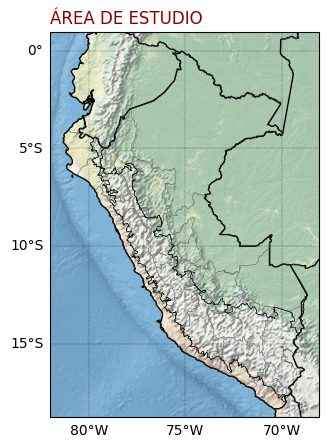

In [ ]:
from matplotlib.image import imread

fig, ax = plt.subplots(figsize = (8,5), subplot_kw = {'projection':crs})

ax.imshow(imread(path_data + 'Copia de NE1_50M_SR_W.tif'), origin='upper', transform=crs,
          extent=[-180, 180, -90, 90])

### Agregar features
ax.add_feature(BORDERS, zorder = 1)
ax.add_feature(COASTLINE, zorder = 1)
DPTO.boundary.plot(ax = ax, edgecolor='dimgrey', linewidth = 0.25, zorder = 1)
REG.boundary.plot(ax = ax, edgecolor='black', linewidth = 0.3, zorder = 2)

grids = ax.gridlines(color='black', alpha=0.5, linestyle='--', linewidth = 0.35,
                    crs = ccrs.PlateCarree(), draw_labels = True,
                    xlocs = mticker.FixedLocator([x for x in np.arange(-80,-50+1, 5)]),
                    ylocs = mticker.FixedLocator([y for y in np.arange(-20,  0+5, 5)]))
grids.xlabels_top = False; grids.ylabels_right = False

ax.set_extent([-82, -68.05, -18.75, 0.95], crs = crs)

ax.set_title('ÁREA DE ESTUDIO', loc = 'left', color = 'darkred')
fig.savefig(path + f'TProg2_AreaEstudio.png',
            transparent = False, pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

# Validación
* https://doi.org/10.1038/sdata.2018.214

* https://www.scielo.br/j/cagro/a/nfcXCJMXKD35kv6DppjpPMy/?lang=en#
*